# Importing necessary libraries and functions

In [66]:
import pandas as pd
from pandas.plotting import table
import numpy as np
import seaborn as sns

import scipy
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

from IPython.display import Image
import pydotplus

import matplotlib.pyplot as plt
%matplotlib inline

seed = 42

# Storing the dataset as a dataframe & formatting.

In [4]:
data = pd.read_csv('/content/bank-additional-full.csv', names=['column'], header=None)
data[['age','job','marital','education','default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed' , 'y']] = data.column.str.split(";",expand=True)
data = data.apply(lambda s:s.str.replace('"', ""))
data.drop(['column'], axis = 1, inplace = True)
data.drop([0], axis = 0, inplace = True)
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
3,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
4,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
5,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41184,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41185,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41187,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


$"yes" → 1 \\
~~~no" → 0  \\
for~target/y~variable $

Also converting variables 'age', 'campaign', 'pdays', 'previous', 'y', 'nr.employed', 'duration' to int & 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed' to float.

In [5]:
data.loc[data['y'] == 'yes', ['y']] = 1
data.loc[data['y'] == 'no', ['y']] = 0
numeric_cols = ['age', 'campaign', 'pdays', 'previous', 'y', 'nr.employed', 'duration' ]
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric)
float_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
data[float_cols] = data[float_cols].astype(float)
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
5,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41184,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41185,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41187,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


Renaming for convenient calling.

In [6]:
data.rename(columns={"emp.var.rate":"emp_var_rate",
                   "cons.price.idx":"cons_price_idx",
                   "cons.conf.idx":"cons_conf_idx",
                   "nr.employed":"nr_employed"}
          ,inplace=True)

In [7]:
data.shape[1] # 20 features

21

In [8]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [9]:
# Type of variables
data.dtypes.sort_values(ascending=True)

age                 int64
previous            int64
pdays               int64
campaign            int64
duration            int64
y                   int64
nr_employed       float64
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
housing            object
loan               object
contact            object
month              object
day_of_week        object
education          object
marital            object
job                object
poutcome           object
default            object
dtype: object

In [10]:
display(data.isnull().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

No null values

<ipython-input-11-0359a80a4122>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(data.corr(), 1)
<ipython-input-11-0359a80a4122>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, vmax=1, vmin = -1, square=True, cmap='BrBG', mask=mask);


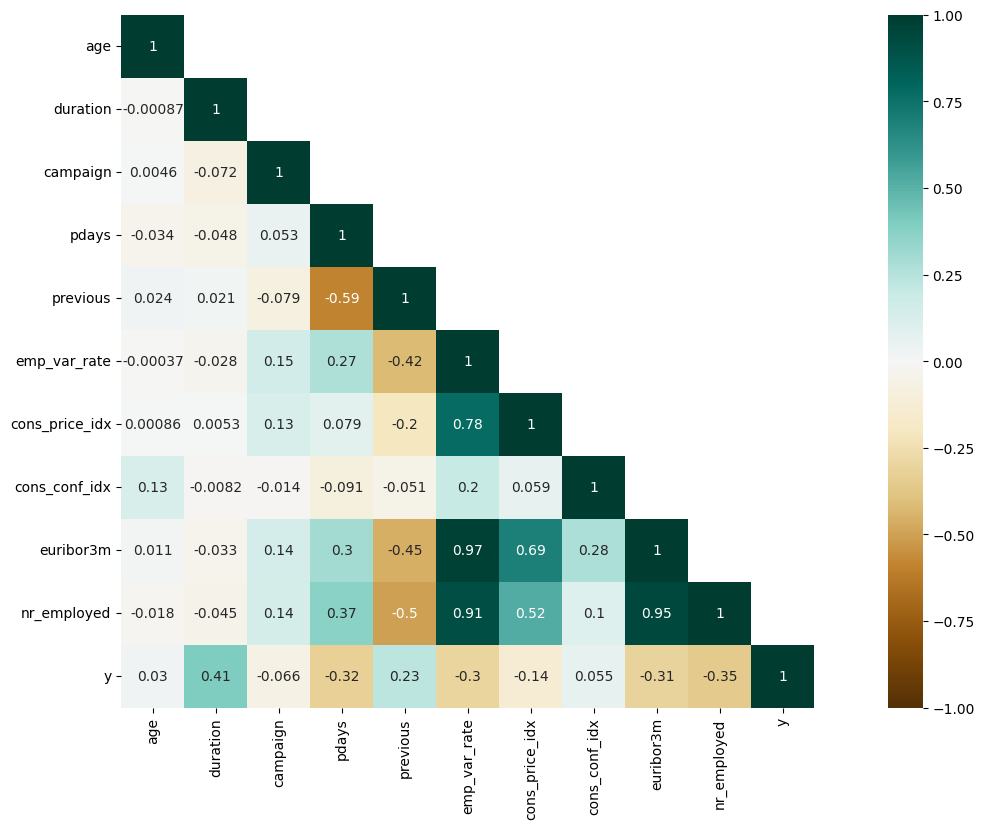

In [11]:
# Visualization of correlations (heatmap)
mask = np.triu(data.corr(), 1)
plt.figure(figsize=(19, 9))
sns.heatmap(data.corr(), annot=True, vmax=1, vmin = -1, square=True, cmap='BrBG', mask=mask);

In [16]:
pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=1636e463501064e426a07b6b90f546caf7cf5a63303297fa0a2bf76badf941d5
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [17]:
import pingouin as pg

# Variable wise analysis

In [23]:
# age                 int64
# previous            int64
# pdays               int64
# campaign            int64
# y                   int64
# nr_employed       float64
# emp_var_rate      float64
# cons_price_idx    float64
# cons_conf_idx     float64
# euribor3m         float64
# housing            object
# loan               object
# contact            object
# month              object
# day_of_week        object
# education          object
# marital            object
# job                object
# poutcome           object
# default            object
# duration           object

Unique values: 78
Max: 98
Min: 17
Mean: 40.02406040594348
Std dev: 10.421249980934048
Variance: 108.60245116511788


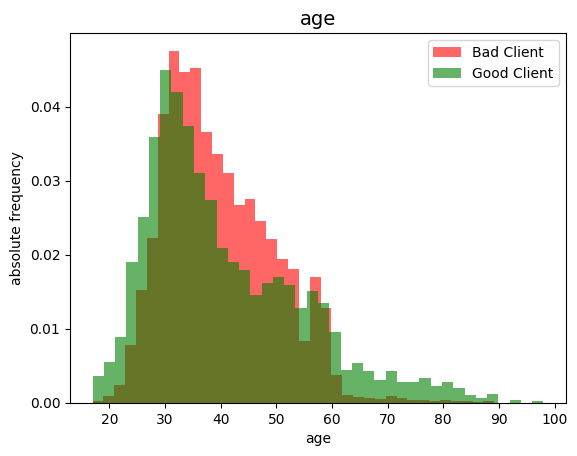

In [24]:
# variable "age" -> age of the client

print(f"Unique values: {data.age.nunique()}")
print(f"Max: {data.age.max()}")
print(f"Min: {data.age.min()}")
print(f"Mean: {data.age.mean()}")
print(f"Std dev: {data.age.std()}")
print(f"Variance: {data.age.var()}")

age_y_0 = data[data['y'] == 0].iloc[:, :1]
age_y_1 = data[data['y'] == 1].iloc[:, :1]
plt.hist(np.array(age_y_0), bins=40, density=True, color="r", alpha = 0.6, label='Bad Client')
plt.hist(np.array(age_y_1), bins=40, density=True, color="g", alpha = 0.6, label='Good Client')
plt.legend(loc='upper right')
plt.title('age', fontsize=14)
plt.xlabel('age')
plt.ylabel('absolute frequency')
plt.show()

Unique values: 8
Max: 7
Min: 0
Mean: 0.17296299893172767
Std dev: 0.4949010798392897
Variance: 0.244927078826095


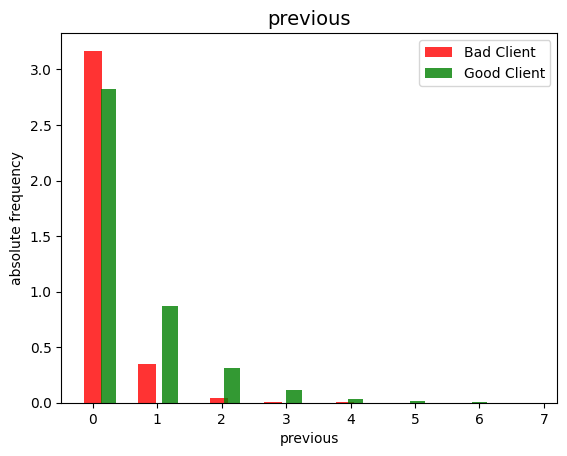

In [25]:
# variable "previous" -> number of previous contacts for this client

print(f"Unique values: {data.previous.nunique()}")
print(f"Max: {data.previous.max()}")
print(f"Min: {data.previous.min()}")
print(f"Mean: {data.previous.mean()}")
print(f"Std dev: {data.previous.std()}")
print(f"Variance: {data.previous.var()}")

previous_y_0 = data[data['y'] == 0].iloc[:,13:14]
previous_y_1 = data[data['y'] == 1].iloc[:,13:14]
plt.hist(np.array(previous_y_0), bins=25, density=True, color="r", alpha = 0.8, label='Bad Client', align='left')
plt.hist(np.array(previous_y_1), bins=25, density=True, color="g", alpha = 0.8, label='Good Client', align='right')
plt.legend(loc='upper right')
plt.title('previous', fontsize=14)
plt.xlabel('previous')
plt.ylabel('absolute frequency')
plt.show()

In [26]:
data[data['y'] == 0].columns.get_loc('emp_var_rate')

15

Unique values: 27
Max: 999
Min: 0
Mean: 962.4754540157328
Std dev: 186.9109073447418
Variance: 34935.68728443465


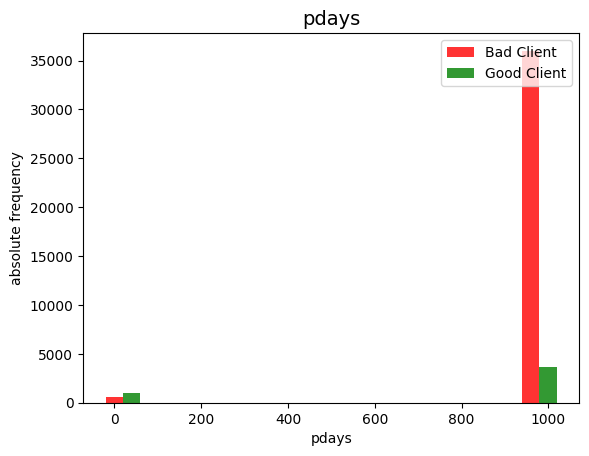

In [27]:
# variable "pdays" -> number of days passed by since the client was last contacted (999 if not contacted before)

print(f"Unique values: {data.pdays.nunique()}")
print(f"Max: {data.pdays.max()}")
print(f"Min: {data.pdays.min()}")
print(f"Mean: {data.pdays.mean()}")
print(f"Std dev: {data.pdays.std()}")
print(f"Variance: {data.pdays.var()}")

pdays_y_0 = data[data['y'] == 0].iloc[:, 12:13]
pdays_y_1 = data[data['y'] == 1].iloc[:, 12:13]
plt.hist(np.array(pdays_y_0), bins=25, density=False, color="r", alpha = 0.8, label='Bad Client', align='left')
plt.hist(np.array(pdays_y_1), bins=25, density=False, color="g", alpha = 0.8, label='Good Client', align='right')
plt.legend(loc='upper right')
plt.title('pdays', fontsize=14)
plt.xlabel('pdays')
plt.ylabel('absolute frequency')
plt.show()

Unique values: 42
Max: 56
Min: 1
Mean: 2.567592502670681
Std dev: 2.7700135429023276
Variance: 7.6729750278623055


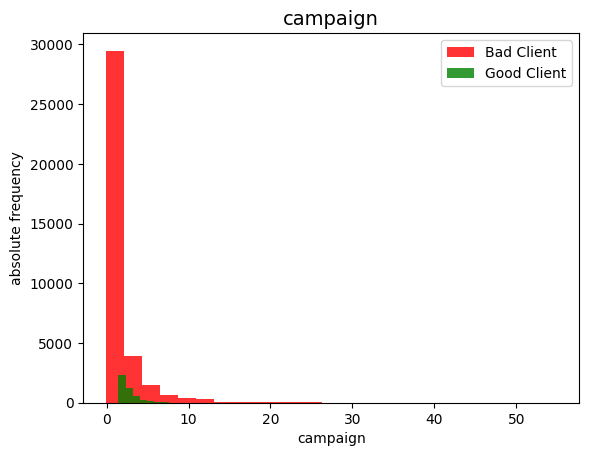

In [28]:
# variable "campaign" -> number of contacts performed in this campaign for this client

print(f"Unique values: {data.campaign.nunique()}")
print(f"Max: {data.campaign.max()}")
print(f"Min: {data.campaign.min()}")
print(f"Mean: {data.campaign.mean()}")
print(f"Std dev: {data.campaign.std()}")
print(f"Variance: {data.campaign.var()}")

campaign_y_0 = data[data['y'] == 0].iloc[:, 11:12]
campaign_y_1 = data[data['y'] == 1].iloc[:, 11:12]
plt.hist(np.array(campaign_y_0), bins=25, density=False, color="r", alpha = 0.8, label='Bad Client', align='left')
plt.hist(np.array(campaign_y_1), bins=25, density=False, color="g", alpha = 0.8, label='Good Client', align='right')
plt.legend(loc='upper right')
plt.title('campaign', fontsize=14)
plt.xlabel('campaign')
plt.ylabel('absolute frequency')
plt.show()

Unique values: 11
Max: 5228.1
Min: 4963.6
Mean: 5167.035910944936
Std dev: 72.25152766826108
Variance: 5220.283250397495


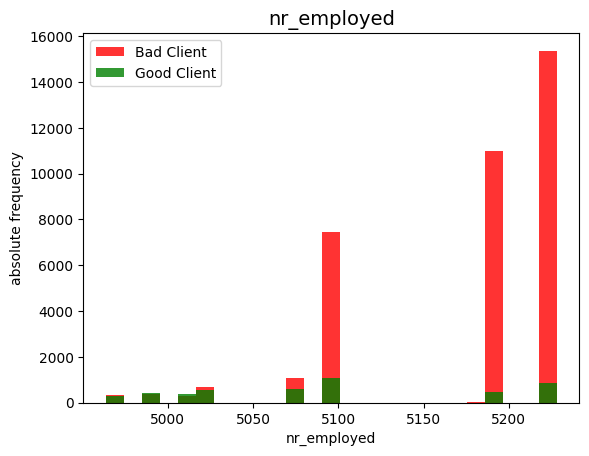

In [29]:
# variable "nr_employed" -> number of employed citizens - quaterly indicator

print(f"Unique values: {data.nr_employed.nunique()}")
print(f"Max: {data.nr_employed.max()}")
print(f"Min: {data.nr_employed.min()}")
print(f"Mean: {data.nr_employed.mean()}")
print(f"Std dev: {data.nr_employed.std()}")
print(f"Variance: {data.nr_employed.var()}")

nr_employed_y_0 = data[data['y'] == 0].iloc[:, 19:20]
nr_employed_y_1 = data[data['y'] == 1].iloc[:, 19:20]
plt.hist(np.array(nr_employed_y_0), bins=25, density=False, color="r", alpha = 0.8, label='Bad Client')
plt.hist(np.array(nr_employed_y_1), bins=25, density=False, color="g", alpha = 0.8, label='Good Client')
plt.legend(loc='upper left')
plt.title('nr_employed', fontsize=14)
plt.xlabel('nr_employed')
plt.ylabel('absolute frequency')
plt.show()

Unique values: 10
Max: 1.4
Min: -3.4
Mean: 0.08188550063125165
Std dev: 1.5709597405170255
Variance: 2.4679145063253203


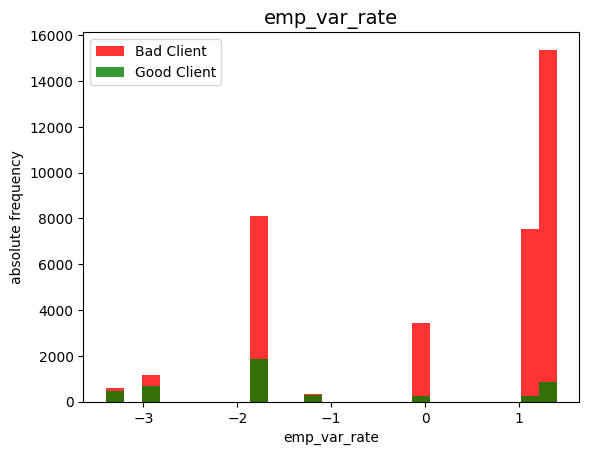

In [30]:
# variable "emp_var_rate" -> number of employed citizens - quaterly indicator

print(f"Unique values: {data.emp_var_rate.nunique()}")
print(f"Max: {data.emp_var_rate.max()}")
print(f"Min: {data.emp_var_rate.min()}")
print(f"Mean: {data.emp_var_rate.mean()}")
print(f"Std dev: {data.emp_var_rate.std()}")
print(f"Variance: {data.emp_var_rate.var()}")

emp_var_rate_y_0 = data[data['y'] == 0].iloc[:, 15:16]
emp_var_rate_y_1 = data[data['y'] == 1].iloc[:, 15:16]
plt.hist(np.array(emp_var_rate_y_0), bins=25, density=False, color="r", alpha = 0.8, label='Bad Client')
plt.hist(np.array(emp_var_rate_y_1), bins=25, density=False, color="g", alpha = 0.8, label='Good Client')
plt.legend(loc='upper left')
plt.title('emp_var_rate', fontsize=14)
plt.xlabel('emp_var_rate')
plt.ylabel('absolute frequency')
plt.show()

and so on....

# Feature Extraction

In [31]:
# numeric dataframe
data_num = data.copy()
data_num = data.select_dtypes(include=["float64", "int64"])
# categoric dataframe
data_cat = data.copy()
data_cat = data.select_dtypes(exclude=["float64", "int64"])

In [32]:
y_num = data_num.y
X_num = data_num.drop(["y"], axis=1)

In [33]:
# pearson correlation p-value
pd.DataFrame(
    [scipy.stats.pearsonr(X_num[col], y_num) for col in X_num.columns],
    columns = ["Pearson Corr.", "p-vlaue"],
    index = X_num.columns,
).round(2)

,Pearson Corr.,p-vlaue
age,0.03,0.0
duration,0.41,0.0
campaign,-0.07,0.0
pdays,-0.32,0.0
previous,0.23,0.0
emp_var_rate,-0.30,0.0
cons_price_idx,-0.14,0.0
cons_conf_idx,0.05,0.0
euribor3m,-0.31,0.0
nr_employed,-0.35,0.0


Keep all values (no p-value < 0.05)

In [34]:
# spearman correlation
spearman_rank = pg.pairwise_corr(data_num, method='spearman').loc[:,['X', 'Y', 'r']]
pos = spearman_rank.sort_values(kind="quicksort", by=['r'], ascending=False).iloc[:5,:]
neg = spearman_rank.sort_values(kind="quicksort", by=['r'], ascending=False).iloc[-5:,:]
con = pd.concat([pos, neg], axis=0)
display(con.reset_index(drop=True))


,X,Y,r
0,emp_var_rate,nr_employed,0.944702
1,emp_var_rate,euribor3m,0.939915
2,euribor3m,nr_employed,0.928857
3,emp_var_rate,cons_price_idx,0.664890
4,cons_price_idx,euribor3m,0.490970
5,pdays,y,-0.324942
6,previous,emp_var_rate,-0.435293
7,previous,nr_employed,-0.438721
8,previous,euribor3m,-0.454724
9,pdays,previous,-0.509583


In [35]:
y_cat = data.y
X_cat = data_cat.copy()

In [36]:
for col in X_cat.columns:
    table = pd.crosstab(X_cat[col], y_cat)
    print()
    display(table)
    _,pval,_,expected_table = scipy.stats.chi2_contingency(table)
    print(f"p-value: {pval:.3f}")

y,0,1
job,,
admin.,9070,1352
blue-collar,8616,638
entrepreneur,1332,124
housemaid,954,106
management,2596,328
retired,1286,434
self-employed,1272,149
services,3646,323
student,600,275


p-value: 0.000



y,0,1
marital,,
divorced,4136,476
married,22396,2532
single,9948,1620
unknown,68,12


p-value: 0.000



y,0,1
education,,
basic.4y,3748,428
basic.6y,2104,188
basic.9y,5572,473
high.school,8484,1031
illiterate,14,4
professional.course,4648,595
university.degree,10498,1670
unknown,1480,251


p-value: 0.000



y,0,1
default,,
no,28391,4197
unknown,8154,443
yes,3,0


p-value: 0.000



y,0,1
housing,,
no,16596,2026
unknown,883,107
yes,19069,2507


p-value: 0.058



y,0,1
loan,,
no,30100,3850
unknown,883,107
yes,5565,683


p-value: 0.579



y,0,1
contact,,
cellular,22291,3853
telephone,14257,787


p-value: 0.000



y,0,1
month,,
apr,2093,539
aug,5523,655
dec,93,89
jul,6525,649
jun,4759,559
mar,270,276
may,12883,886
nov,3685,416
oct,403,315


p-value: 0.000



y,0,1
day_of_week,,
fri,6981,846
mon,7667,847
thu,7578,1045
tue,7137,953
wed,7185,949


p-value: 0.000



y,0,1
poutcome,,
failure,3647,605
nonexistent,32422,3141
success,479,894


p-value: 0.000


Remove housing, loan & default

In [37]:
data_t = data.copy()

In [38]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.3 MB/s eta 0:00:00


In [39]:
from category_encoders import BinaryEncoder

# data_t has encoded and necessary features to train the model

In [40]:
# Replacing unknown values in categoric types by the mode
data_t.marital.replace(to_replace="unknown", value=np.nan, inplace=True)
data_t['marital'] = data_t.marital.fillna(data_t.marital.value_counts().index[0])
print(data_t.marital.nunique())
# using ohe
marital_ohe = pd.get_dummies(data_t.marital)
binary_encoder_marital = BinaryEncoder()
marital_bin = binary_encoder_marital.fit_transform(data_t.marital)
data_t.drop(["marital"],axis=1, inplace=True)
data_t = pd.concat([data_t, marital_ohe], axis=1)
data_t

3


,age,job,education,default,housing,loan,contact,month,day_of_week,duration,...,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,divorced,married,single
1,56,housemaid,basic.4y,no,no,no,telephone,may,mon,261,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0
2,57,services,high.school,unknown,no,no,telephone,may,mon,149,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0
3,37,services,high.school,no,yes,no,telephone,may,mon,226,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0
4,40,admin.,basic.6y,no,no,no,telephone,may,mon,151,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0
5,56,services,high.school,no,no,yes,telephone,may,mon,307,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41184,73,retired,professional.course,no,yes,no,cellular,nov,fri,334,...,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,0,1,0
41185,46,blue-collar,professional.course,no,no,no,cellular,nov,fri,383,...,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,0,1,0
41186,56,retired,university.degree,no,yes,no,cellular,nov,fri,189,...,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0,0,1,0
41187,44,technician,professional.course,no,no,no,cellular,nov,fri,442,...,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1,0,1,0


In [41]:
data_t.job.replace(to_replace="unknown", value=np.nan, inplace=True)
data_t['job'] = data_t.job.fillna(data_t.job.value_counts().index[0])
print(data_t.job.nunique())
# using ohe
job_ohe = pd.get_dummies(data_t.job)
binary_encoder_job = BinaryEncoder()
job_bin = binary_encoder_job.fit_transform(data_t.job)
data_t.drop(["job"],axis=1, inplace=True)
data_t = pd.concat([data_t, job_ohe], axis=1)
data_t

11


,age,education,default,housing,loan,contact,month,day_of_week,duration,campaign,...,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
1,56,basic.4y,no,no,no,telephone,may,mon,261,1,...,0,0,1,0,0,0,0,0,0,0
2,57,high.school,unknown,no,no,telephone,may,mon,149,1,...,0,0,0,0,0,0,1,0,0,0
3,37,high.school,no,yes,no,telephone,may,mon,226,1,...,0,0,0,0,0,0,1,0,0,0
4,40,basic.6y,no,no,no,telephone,may,mon,151,1,...,0,0,0,0,0,0,0,0,0,0
5,56,high.school,no,no,yes,telephone,may,mon,307,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41184,73,professional.course,no,yes,no,cellular,nov,fri,334,1,...,0,0,0,0,1,0,0,0,0,0
41185,46,professional.course,no,no,no,cellular,nov,fri,383,1,...,1,0,0,0,0,0,0,0,0,0
41186,56,university.degree,no,yes,no,cellular,nov,fri,189,2,...,0,0,0,0,1,0,0,0,0,0
41187,44,professional.course,no,no,no,cellular,nov,fri,442,1,...,0,0,0,0,0,0,0,0,1,0


In [42]:
data_t.education.replace(to_replace="unknown", value=np.nan, inplace=True)
data_t['education'] = data_t.education.fillna(data_t.education.value_counts().index[0])
print(data_t.education.nunique())
# using ordinal
data_t['education'] = data_t.education.map({"university.degree":7,
                                                "professional.course":6,
                                                "high.school":5,"basic.9y":4,
                                                "basic.6y":3, "basic.4y":2,
                                                "illiterate":1 })
data_t

7


,age,education,default,housing,loan,contact,month,day_of_week,duration,campaign,...,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
1,56,2,no,no,no,telephone,may,mon,261,1,...,0,0,1,0,0,0,0,0,0,0
2,57,5,unknown,no,no,telephone,may,mon,149,1,...,0,0,0,0,0,0,1,0,0,0
3,37,5,no,yes,no,telephone,may,mon,226,1,...,0,0,0,0,0,0,1,0,0,0
4,40,3,no,no,no,telephone,may,mon,151,1,...,0,0,0,0,0,0,0,0,0,0
5,56,5,no,no,yes,telephone,may,mon,307,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41184,73,6,no,yes,no,cellular,nov,fri,334,1,...,0,0,0,0,1,0,0,0,0,0
41185,46,6,no,no,no,cellular,nov,fri,383,1,...,1,0,0,0,0,0,0,0,0,0
41186,56,7,no,yes,no,cellular,nov,fri,189,2,...,0,0,0,0,1,0,0,0,0,0
41187,44,6,no,no,no,cellular,nov,fri,442,1,...,0,0,0,0,0,0,0,0,1,0


In [43]:
# drop 'default' variable
# drop 'housing' and 'loan' variable

data_t.drop(["default", "housing", "loan"], axis=1, inplace=True)
data_t

,age,education,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,...,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
1,56,2,telephone,may,mon,261,1,999,0,nonexistent,...,0,0,1,0,0,0,0,0,0,0
2,57,5,telephone,may,mon,149,1,999,0,nonexistent,...,0,0,0,0,0,0,1,0,0,0
3,37,5,telephone,may,mon,226,1,999,0,nonexistent,...,0,0,0,0,0,0,1,0,0,0
4,40,3,telephone,may,mon,151,1,999,0,nonexistent,...,0,0,0,0,0,0,0,0,0,0
5,56,5,telephone,may,mon,307,1,999,0,nonexistent,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41184,73,6,cellular,nov,fri,334,1,999,0,nonexistent,...,0,0,0,0,1,0,0,0,0,0
41185,46,6,cellular,nov,fri,383,1,999,0,nonexistent,...,1,0,0,0,0,0,0,0,0,0
41186,56,7,cellular,nov,fri,189,2,999,0,nonexistent,...,0,0,0,0,1,0,0,0,0,0
41187,44,6,cellular,nov,fri,442,1,999,0,nonexistent,...,0,0,0,0,0,0,0,0,1,0


In [44]:
data_t.poutcome.replace(to_replace="unknown", value=np.nan, inplace=True)
data_t['poutcome'] = data_t.poutcome.fillna(data_t.poutcome.value_counts().index[0])
print(data_t.poutcome.nunique())
# using ohe
poutcome_ohe = pd.get_dummies(data_t.poutcome)
binary_encoder_poutcome = BinaryEncoder()
poutcome_bin = binary_encoder_poutcome.fit_transform(data_t.poutcome)
data_t.drop(["poutcome"],axis=1, inplace=True)
data_t = pd.concat([data_t, poutcome_ohe], axis=1)
data_t

3


,age,education,contact,month,day_of_week,duration,campaign,pdays,previous,emp_var_rate,...,management,retired,self-employed,services,student,technician,unemployed,failure,nonexistent,success
1,56,2,telephone,may,mon,261,1,999,0,1.1,...,0,0,0,0,0,0,0,0,1,0
2,57,5,telephone,may,mon,149,1,999,0,1.1,...,0,0,0,1,0,0,0,0,1,0
3,37,5,telephone,may,mon,226,1,999,0,1.1,...,0,0,0,1,0,0,0,0,1,0
4,40,3,telephone,may,mon,151,1,999,0,1.1,...,0,0,0,0,0,0,0,0,1,0
5,56,5,telephone,may,mon,307,1,999,0,1.1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41184,73,6,cellular,nov,fri,334,1,999,0,-1.1,...,0,1,0,0,0,0,0,0,1,0
41185,46,6,cellular,nov,fri,383,1,999,0,-1.1,...,0,0,0,0,0,0,0,0,1,0
41186,56,7,cellular,nov,fri,189,2,999,0,-1.1,...,0,1,0,0,0,0,0,0,1,0
41187,44,6,cellular,nov,fri,442,1,999,0,-1.1,...,0,0,0,0,0,1,0,0,1,0


In [45]:
data_t.contact.replace(to_replace="unknown", value=np.nan, inplace=True)
data_t['contact'] = data_t.contact.fillna(data_t.contact.value_counts().index[0])
print(data_t.contact.nunique())
# using ohe
contact_ohe = pd.get_dummies(data_t.contact)
binary_encoder_contact = BinaryEncoder()
contact_bin = binary_encoder_contact.fit_transform(data_t.contact)
data_t.drop(["contact"],axis=1, inplace=True)
data_t = pd.concat([data_t, contact_ohe], axis=1)
data_t

2


,age,education,month,day_of_week,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,...,self-employed,services,student,technician,unemployed,failure,nonexistent,success,cellular,telephone
1,56,2,may,mon,261,1,999,0,1.1,93.994,...,0,0,0,0,0,0,1,0,0,1
2,57,5,may,mon,149,1,999,0,1.1,93.994,...,0,1,0,0,0,0,1,0,0,1
3,37,5,may,mon,226,1,999,0,1.1,93.994,...,0,1,0,0,0,0,1,0,0,1
4,40,3,may,mon,151,1,999,0,1.1,93.994,...,0,0,0,0,0,0,1,0,0,1
5,56,5,may,mon,307,1,999,0,1.1,93.994,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41184,73,6,nov,fri,334,1,999,0,-1.1,94.767,...,0,0,0,0,0,0,1,0,1,0
41185,46,6,nov,fri,383,1,999,0,-1.1,94.767,...,0,0,0,0,0,0,1,0,1,0
41186,56,7,nov,fri,189,2,999,0,-1.1,94.767,...,0,0,0,0,0,0,1,0,1,0
41187,44,6,nov,fri,442,1,999,0,-1.1,94.767,...,0,0,0,1,0,0,1,0,1,0


In [46]:
data_t.month.replace(to_replace="unknown", value=np.nan, inplace=True)
data_t['month'] = data_t.month.fillna(data_t.month.value_counts().index[0])
print(data_t.month.nunique())
# using ohe
month_ohe = pd.get_dummies(data_t.month)
binary_encoder_month = BinaryEncoder()
month_bin = binary_encoder_month.fit_transform(data_t.month)
data_t.drop(["month"],axis=1, inplace=True)
data_t = pd.concat([data_t, month_ohe], axis=1)
data_t

10


,age,education,day_of_week,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,...,apr,aug,dec,jul,jun,mar,may,nov,oct,sep
1,56,2,mon,261,1,999,0,1.1,93.994,-36.4,...,0,0,0,0,0,0,1,0,0,0
2,57,5,mon,149,1,999,0,1.1,93.994,-36.4,...,0,0,0,0,0,0,1,0,0,0
3,37,5,mon,226,1,999,0,1.1,93.994,-36.4,...,0,0,0,0,0,0,1,0,0,0
4,40,3,mon,151,1,999,0,1.1,93.994,-36.4,...,0,0,0,0,0,0,1,0,0,0
5,56,5,mon,307,1,999,0,1.1,93.994,-36.4,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41184,73,6,fri,334,1,999,0,-1.1,94.767,-50.8,...,0,0,0,0,0,0,0,1,0,0
41185,46,6,fri,383,1,999,0,-1.1,94.767,-50.8,...,0,0,0,0,0,0,0,1,0,0
41186,56,7,fri,189,2,999,0,-1.1,94.767,-50.8,...,0,0,0,0,0,0,0,1,0,0
41187,44,6,fri,442,1,999,0,-1.1,94.767,-50.8,...,0,0,0,0,0,0,0,1,0,0


In [47]:
data_t.day_of_week.replace(to_replace="unknown", value=np.nan, inplace=True)
data_t['day_of_week'] = data_t.day_of_week.fillna(data_t.day_of_week.value_counts().index[0])
print(data_t.day_of_week.nunique())
# using ohe
day_of_week_ohe = pd.get_dummies(data_t.day_of_week)
binary_encoder_day_of_week = BinaryEncoder()
day_of_week_bin = binary_encoder_day_of_week.fit_transform(data_t.day_of_week)
data_t.drop(["day_of_week"],axis=1, inplace=True)
data_t = pd.concat([data_t, day_of_week_ohe], axis=1)
data_t

5


,age,education,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,...,mar,may,nov,oct,sep,fri,mon,thu,tue,wed
1,56,2,261,1,999,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,0,0,1,0,0,0
2,57,5,149,1,999,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,0,0,1,0,0,0
3,37,5,226,1,999,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,0,0,1,0,0,0
4,40,3,151,1,999,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,0,0,1,0,0,0
5,56,5,307,1,999,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41184,73,6,334,1,999,0,-1.1,94.767,-50.8,1.028,...,0,0,1,0,0,1,0,0,0,0
41185,46,6,383,1,999,0,-1.1,94.767,-50.8,1.028,...,0,0,1,0,0,1,0,0,0,0
41186,56,7,189,2,999,0,-1.1,94.767,-50.8,1.028,...,0,0,1,0,0,1,0,0,0,0
41187,44,6,442,1,999,0,-1.1,94.767,-50.8,1.028,...,0,0,1,0,0,1,0,0,0,0


In [48]:
data_t.dtypes

age                 int64
education           int64
duration            int64
campaign            int64
pdays               int64
previous            int64
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                   int64
divorced            uint8
married             uint8
single              uint8
admin.              uint8
blue-collar         uint8
entrepreneur        uint8
housemaid           uint8
management          uint8
retired             uint8
self-employed       uint8
services            uint8
student             uint8
technician          uint8
unemployed          uint8
failure             uint8
nonexistent         uint8
success             uint8
cellular            uint8
telephone           uint8
apr                 uint8
aug                 uint8
dec                 uint8
jul                 uint8
jun                 uint8
mar                 uint8
may                 uint8
nov         

In [49]:
data_t.columns

Index(['age', 'education', 'duration', 'campaign', 'pdays', 'previous',
       'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m',
       'nr_employed', 'y', 'divorced', 'married', 'single', 'admin.',
       'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired',
       'self-employed', 'services', 'student', 'technician', 'unemployed',
       'failure', 'nonexistent', 'success', 'cellular', 'telephone', 'apr',
       'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep', 'fri',
       'mon', 'thu', 'tue', 'wed'],
      dtype='object')

In [50]:
y_numcat = data_t.y
X_numcat = data_t.drop(["y"], axis=1)
new_pearson = pd.DataFrame(
    [scipy.stats.pearsonr(X_numcat[col], y_numcat) for col in X_numcat.columns],
    columns = ["Pearson Corr.", "p-value"],
    index = X_numcat.columns,
).round(2).sort_values(by="p-value", ascending=False)
display(new_pearson)

,Pearson Corr.,p-value
management,-0.00,0.93
self-employed,-0.00,0.34
technician,-0.01,0.21
wed,0.01,0.20
housemaid,-0.01,0.19
fri,-0.01,0.16
tue,0.01,0.10
aug,-0.01,0.07
jun,-0.01,0.06
divorced,-0.01,0.03


In [51]:
columns_to_drop = []
for item in new_pearson.index:
    if new_pearson['p-value'][item] > 0.05 or new_pearson['p-value'][item] == 'NaN':
        columns_to_drop.append(item)

In [52]:
columns_to_drop

['management',
 'self-employed',
 'technician',
 'wed',
 'housemaid',
 'fri',
 'tue',
 'aug',
 'jun']

In [53]:
data_t.drop(columns_to_drop, axis=1, inplace=True)

In [54]:
data_t.shape

(41188, 37)

In [55]:
# splitting into train and test
train_set, test_set = train_test_split(data_t, test_size=0.2, random_state = seed)
X_train = train_set.drop(['y'], axis = 1)
y_train = train_set['y']

X_test = test_set.drop(['y'], axis=1)
y_test = test_set['y']

In [56]:
y_preds_all_bad = np.zeros(y_test.shape)
y_preds_all_bad

array([0., 0., 0., ..., 0., 0., 0.])

In [57]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_bad).ravel()

print(f'''
Number of True Negatives: {tn}
Number of True Positives: {tp}
Number of False Negatives: {fn}
Number of False Positives: {fp}
''')

print(confusion_matrix(y_test, y_preds_all_bad))

baseline_all_bad = fp*500+fn*2000
print(f'''
BANK TOTAL COSTS: {fp*500+fn*2000} €
(Scenario: if all clients where considered to be bad candidates but subscribed the bank deposit.)
''')


Number of True Negatives: 7303
Number of True Positives: 0
Number of False Negatives: 935
Number of False Positives: 0

[[7303    0]
 [ 935    0]]

BANK TOTAL COSTS: 1870000 € 
(Scenario: if all clients where considered to be bad candidates but subscribed the bank deposit.)



In [58]:
y_preds_all_good = np.ones(y_test.shape)
y_preds_all_good

array([1., 1., 1., ..., 1., 1., 1.])

In [59]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_all_good).ravel()

print("")
print('Number of True Negatives:', tn)
print('Number of True Positives:', tp)
print('Number of False Negatives:', fn)
print('Number of False Positives:', fp)
print("")
print(confusion_matrix(y_test, y_preds_all_good))

baseline_all_good = fp*500+fn*2000
print(f'''
BANK TOTAL COST: {fp*500+fn*2000} €
(Scenario: if all clients where considered to be good candidates but didn't subscribe the deposit.
''')


Number of True Negatives: 0
Number of True Positives: 935
Number of False Negatives: 0
Number of False Positives: 7303

[[   0 7303]
 [   0  935]]

BANK TOTAL COST: 3651500 €
(Scenario: if all clients where considered to be good candidates but didn't subscribe the deposit.



In [60]:
# Cost functions

def total_cost(y_test, y_preds, threshold = 0.5):

    tn, fp, fn, tp = confusion_matrix(y_test == 1, y_preds > threshold).ravel()

    cost_fn = fn*2000
    cost_fp = fp*500

    return cost_fn + cost_fp


In [63]:
def min_cost_threshold(y_test, y_preds):
    costs = {}
    for threshold in np.arange(0, 1.1, 0.1):
        costs[round(threshold, 1)] = total_cost(y_test, y_preds, threshold = threshold)

    plt.plot(list(costs.keys()), list(costs.values()))

    data_cost = pd.DataFrame(np.array([list(costs.keys())]).T)

    data_cost.columns =['Threshold']

    data_cost['Total_Cost'] = np.array([list(costs.values())]).T

    display(data_cost)

    plt.ylabel('Cost')
    plt.xlabel('Threshold')
    plt.show()

    min_cost = data_cost['Total_Cost'].min()
    min_thres = data_cost.loc[data_cost['Total_Cost'] == min_cost, 'Threshold'].iloc[0]

    print('Threshold_min_cost:', min_thres)


In [64]:
# ROC Curve: Area Under the Curve

def auc_roc_plot(y_test, y_preds):

    fpr, tpr, thresholds = roc_curve(y_test,y_preds)
    roc_auc = auc(fpr, tpr)

    print(roc_auc)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
